In [41]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler 
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
import missingno as msno
from sklearn.utils import shuffle 
from category_encoders import TargetEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
sns.set(rc = {'figure.figsize': (20, 20)})
%matplotlib inline 

In [42]:
df = pd.read_json("cars_data (2).json")
df = df.dropna()
df.head(2)

,Prix,year,origin,firstCirculationDate,firstHand,mileage,energy,gearbox,externalColor,doors,ratedHorsePower,powerDIN,critAir,co2,marqueModele,owners
1,22770,2017,France,23/07/2017,Non,45 410 km,Essence,Manuelle,noir,3.0,11 CV,(DIN) 208 ch,1,125 g/km,PEUGEOT 208 GTI,2.0
2,15100,2018,France,11/04/2018,Non,131 044 km,Diesel,Manuelle,orange metal,5.0,5 CV,(DIN) 110 ch,2,98 g/km,RENAULT CAPTUR,3.0


In [44]:
# Prétraitement
df['Prix'] = df['Prix'].astype(int)
df['year'] = df['year'].astype(int)
df['origin'] = df['origin'].replace({'Importé': 1, 'France': 0})
df['firstHand'] = df['firstHand'].replace({'Oui': 1, 'Non': 0})
df['mileage'] = df['mileage'].str.extract('(\d+)').astype(int) 
df['gearbox'] = df['gearbox'].replace({'Automatique': 1, 'Manuelle': 0})
df['ratedHorsePower'] = df['ratedHorsePower'].str.extract('(\d+)').astype(int)
df['powerDIN'] = df['powerDIN'].str.extract('(\d+)').astype(int)
df['doors'] = df['doors'].astype(int)
df['co2'] = df['co2'].str.extract('(\d+)').astype(int) 
df['critAir'] = df['critAir'].str.extract('(\d+)').astype(int) 
df['energy'] = df['energy'].replace({'Diesel' : 0,'Essence' : 1,'Hybride essence électrique' : 2,'Electrique' : 3,'Bicarburation essence bioéthanol' : 4,'Hybride diesel électrique' : 5, 'Bicarburation essence GPL':6})
df = df.drop(["firstCirculationDate", "externalColor", "marqueModele"], axis=1)

In [45]:
df['energy'].unique()

array([1, 0, 2, 3, 6])

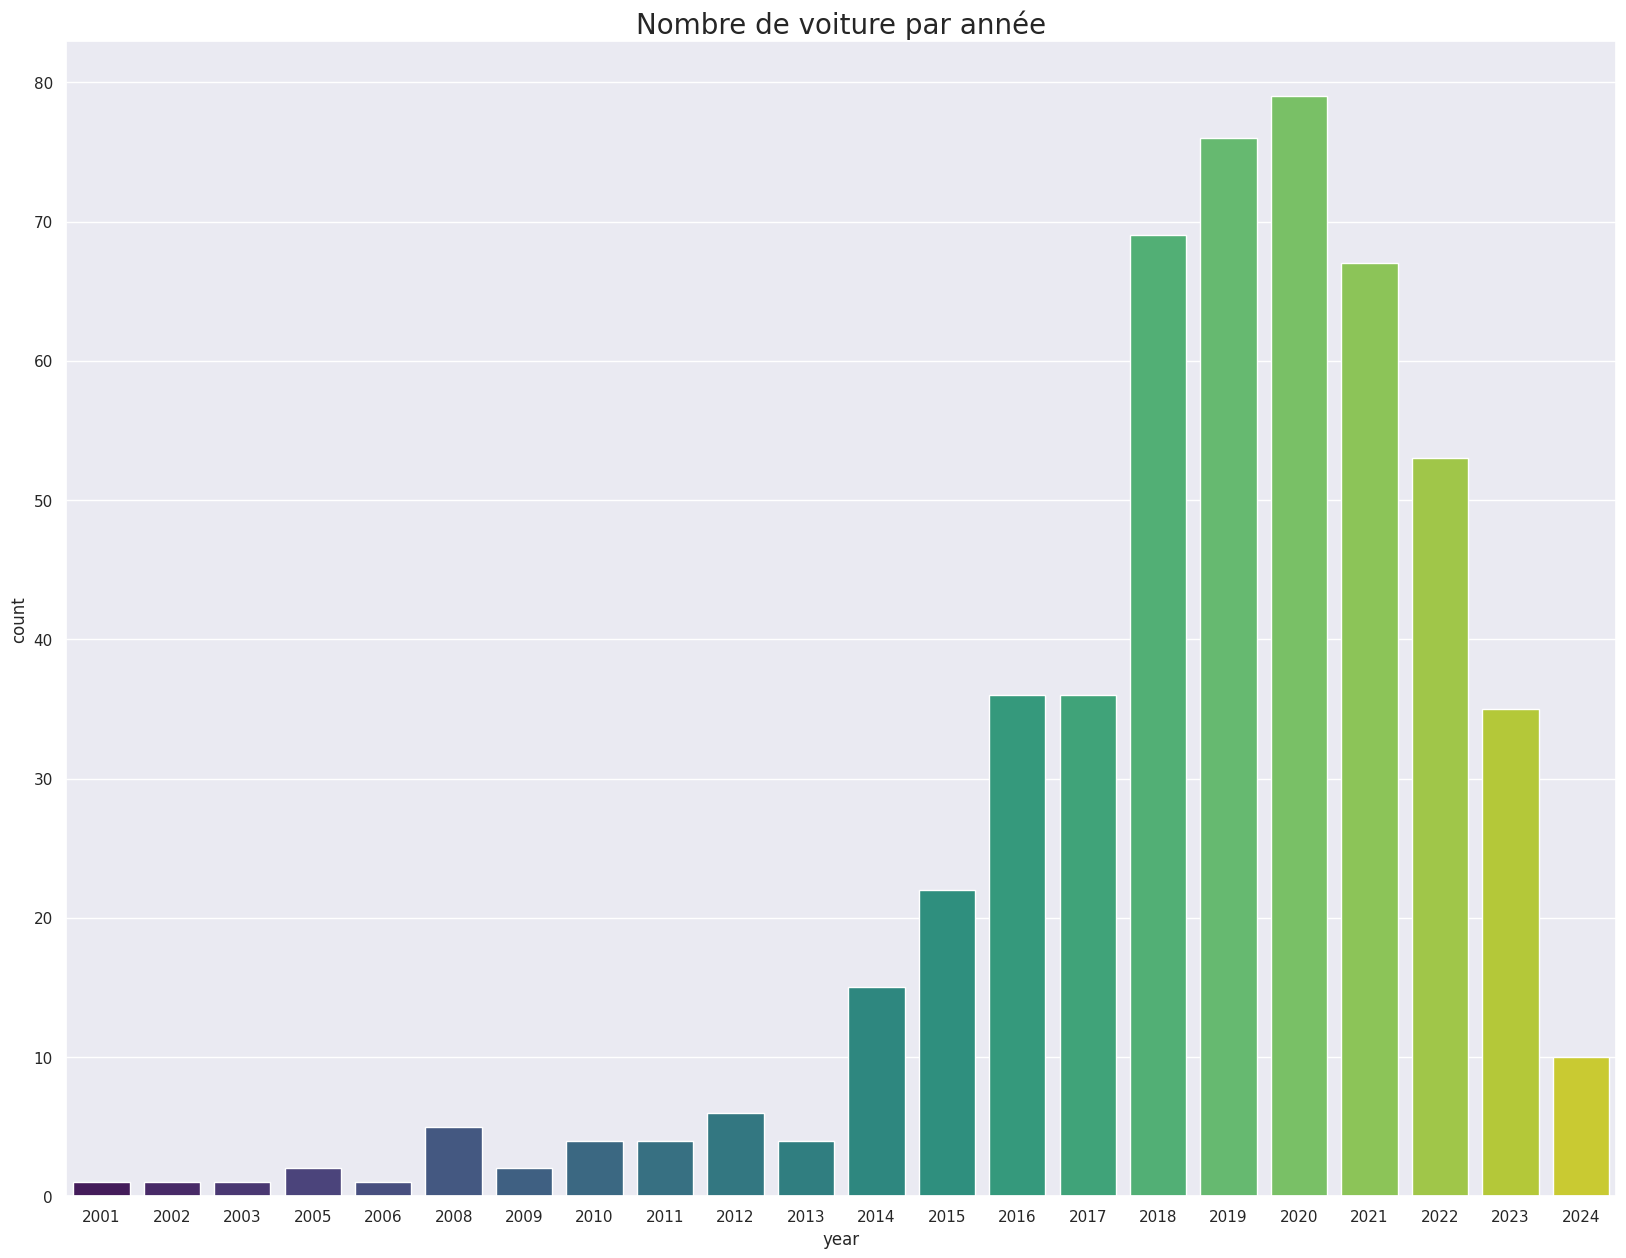

In [46]:
plt.figure(figsize = (20, 15))
sns.countplot(x=df.year, palette = 'viridis')
plt.title("Nombre de voiture par année", fontsize = 20)
plt.show()

<Axes: >

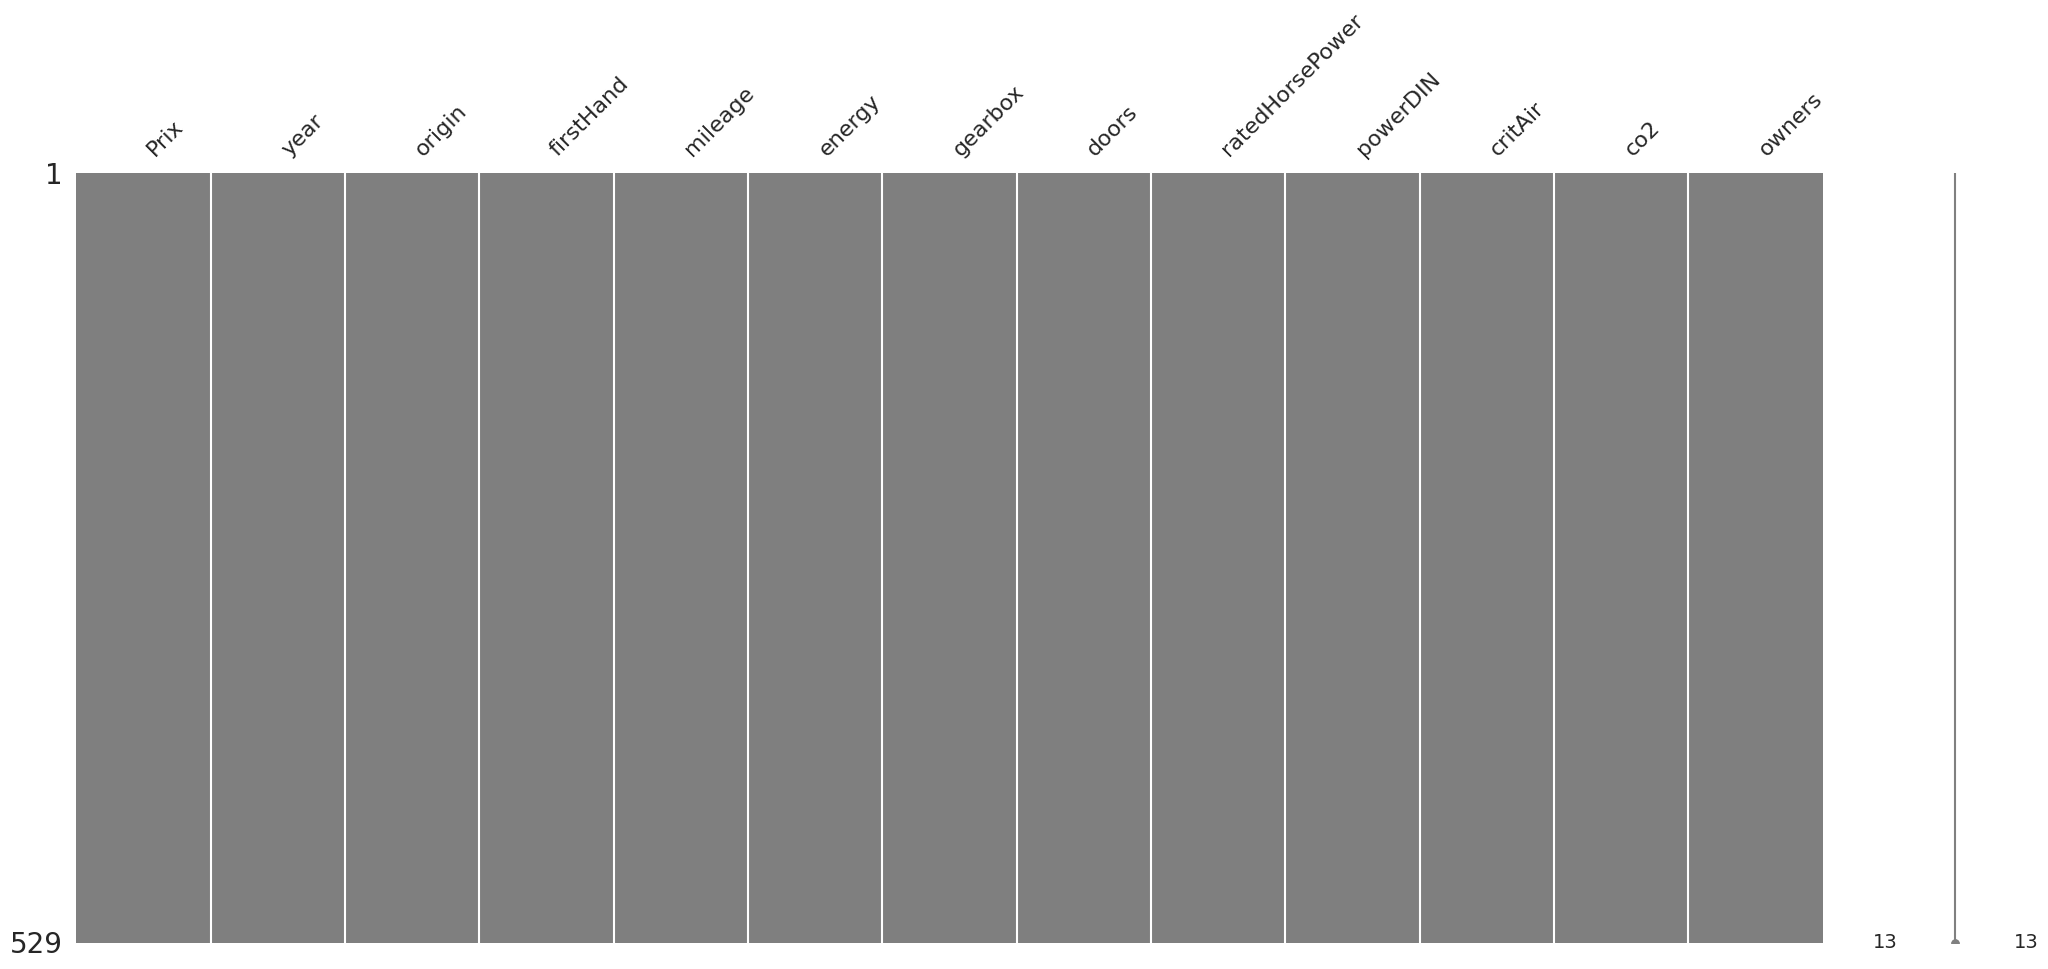

In [47]:
msno.matrix(df, color = (0.5, 0.5, 0.5))

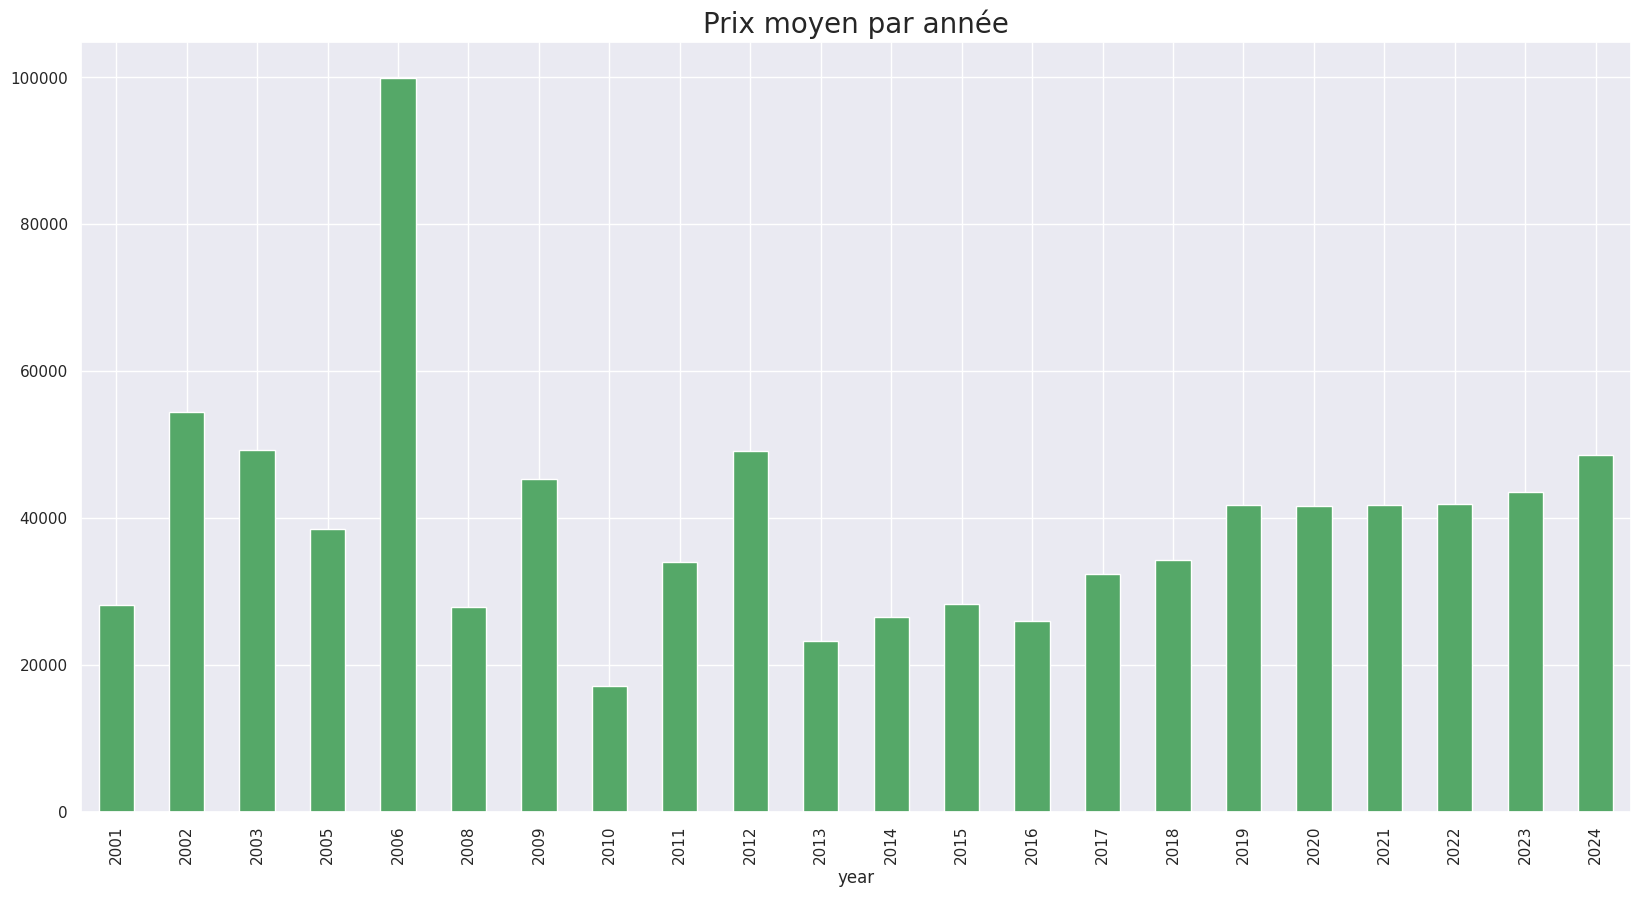

In [48]:
plt.figure(figsize = (20, 10))
df.groupby('year')['Prix'].mean().plot(kind = 'bar', color = 'g')
plt.title("Prix moyen par année", fontsize = 20)
plt.show()

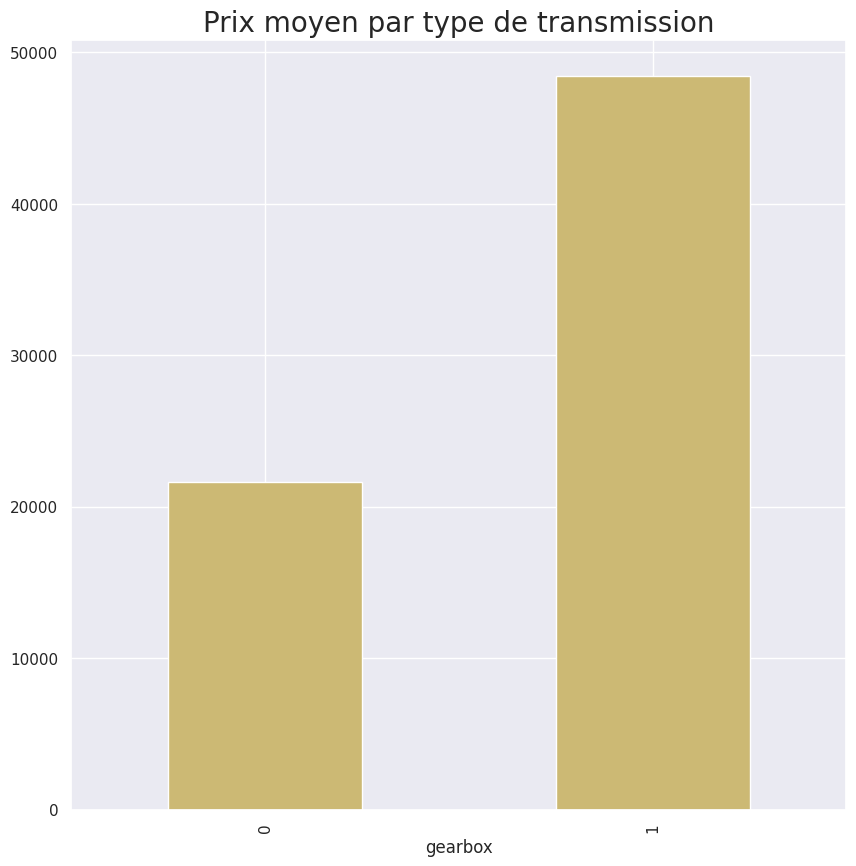

In [49]:
plt.figure(figsize = (10, 10))
df.groupby('gearbox')['Prix'].mean().plot(kind = 'bar', color = 'y')
plt.title("Prix moyen par type de transmission", fontsize = 20)
plt.show()

<Axes: >

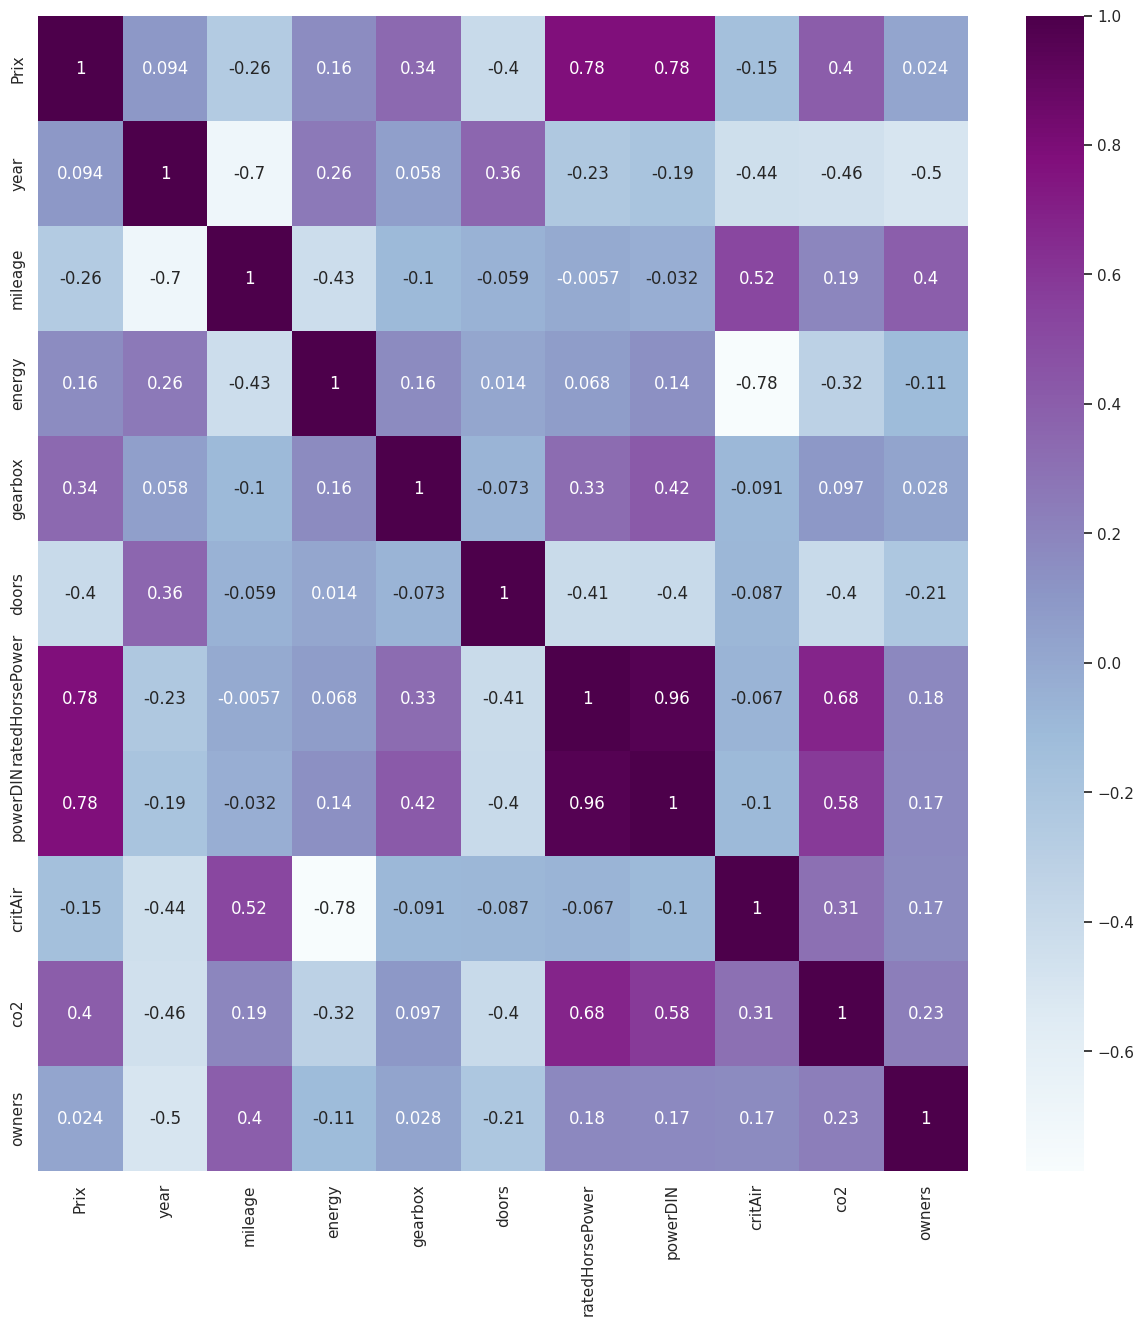

In [50]:
#"Prix", "year", "origin", "firstHand", "mileage", "energy", "gearbox", "doors", "ratedHorsePower", "powerDIN", "critAir", "co2", "owners"
plt.figure(figsize = (15, 15))
numeric_columns = ["Prix", "year", "mileage", "energy", "gearbox", "doors", "ratedHorsePower", "powerDIN", "critAir", "co2", "owners"]
heatmap_data = df[numeric_columns].corr()

sns.heatmap(heatmap_data, cmap = 'BuPu', annot = True)

In [51]:
X = df.drop(['Prix'], axis = 1)
y = df['Prix']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)


In [52]:
(X_train.shape), (X_test.shape)

((423, 12), (106, 12))

In [53]:
(y_train.shape), (y_test.shape)

((423,), (106,))

In [54]:
df

,Prix,year,origin,firstHand,mileage,energy,gearbox,doors,ratedHorsePower,powerDIN,critAir,co2,owners
1,22770,2017,0,0,45,1,0,3,11,208,1,125,2.0
2,15100,2018,0,0,131,0,0,5,5,110,2,98,3.0
3,26710,2018,0,0,88,1,0,5,7,131,1,124,2.0
5,16780,2019,0,0,78,1,0,3,5,110,1,100,2.0
10,215120,2020,1,0,30,1,1,2,34,450,1,207,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,21380,2019,0,0,107,0,0,5,6,116,2,115,1.0
1494,24550,2013,0,0,222,0,1,3,13,200,2,216,2.0
1496,90620,2018,1,0,56,1,1,5,25,361,1,212,2.0
1499,18370,2021,0,0,54,3,1,5,4,136,0,0,2.0


In [55]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_new = scaler.transform(X_train)
X_test_new = scaler.transform(X_test)

In [56]:
X_train_new.shape

(423, 12)

In [57]:
# Regression linéaire

model = LinearRegression()
model.fit(X_train_new, y_train)

LinearRegression()

In [58]:

y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Prédiction'])

In [59]:
y_predict.head()


,Prédiction
0,44846.039149
1,13026.854422
2,38884.535941
3,12882.574871
4,37032.109833


In [60]:

y_test.to_frame().head()

,Prix
1128,34630
1356,16720
1205,29840
868,29360
858,13440


In [61]:
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)
results.head()

,Prédiction,Prix
0,44846.039149,34630
1,13026.854422,16720
2,38884.535941,29840
3,12882.574871,29360
4,37032.109833,13440


In [62]:
# Stockage des erreurs des différents algo de prédictions
error_mean_square = []
error_mean_absolute = []
error_mean_square.append(int(mean_squared_error(y_predict, y_test)))
error_mean_absolute.append(int(mean_absolute_error(y_predict, y_test)))

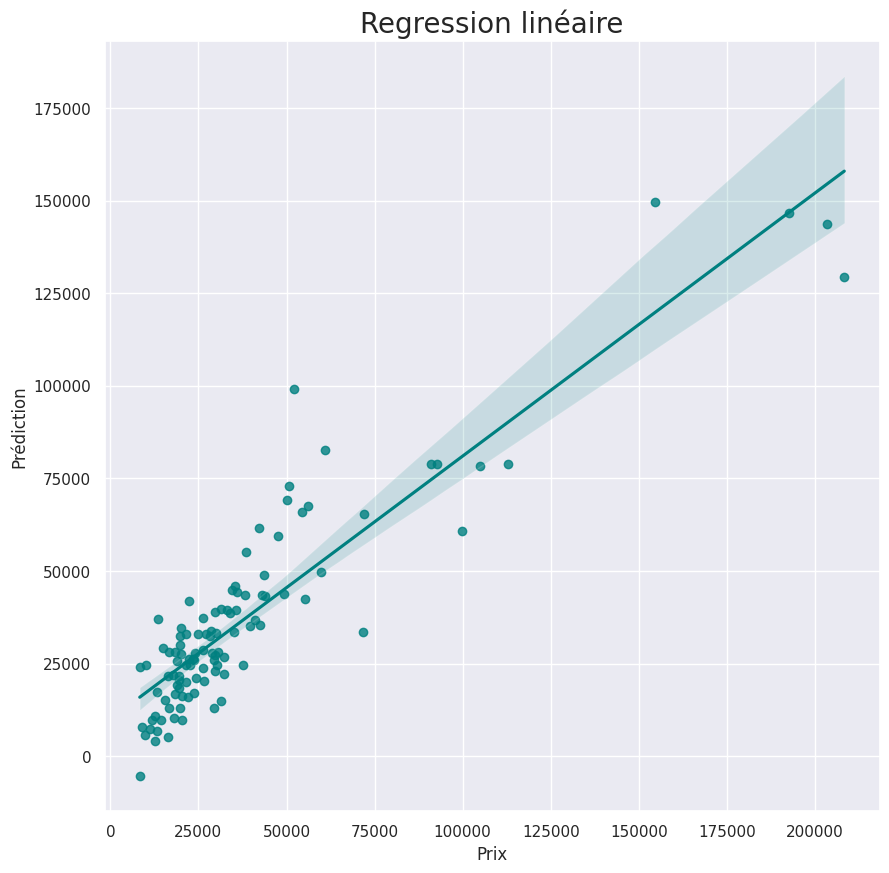

In [63]:
plt.figure(figsize = (10, 10))
sns.regplot(data = results, y = 'Prédiction', x = 'Prix', color = 'teal', marker = 'o')
plt.title("Regression linéaire", fontsize = 20)
plt.show()

In [64]:
# Regression voisine
model = KNeighborsRegressor(n_neighbors = 2)
model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Prédiction'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

error_mean_square.append(int(mean_squared_error(y_predict, y_test)))
error_mean_absolute.append(int(mean_absolute_error(y_predict, y_test)))

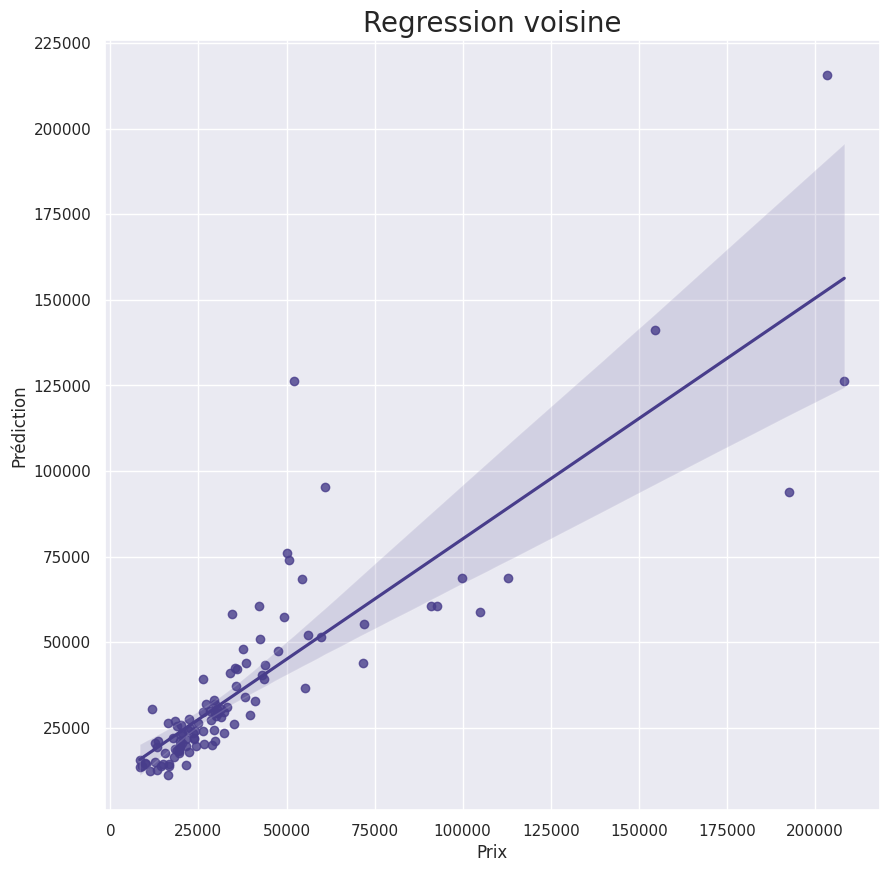

In [65]:
plt.figure(figsize = (10, 10))
sns.regplot(data = results, y = 'Prédiction', x = 'Prix', color = 'darkslateblue', marker = 'o')
plt.title("Regression voisine", fontsize = 20)
plt.show()

In [66]:
# Décision tree
model = DecisionTreeRegressor(splitter = 'random')
model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Prédiction'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

error_mean_square.append(int(mean_squared_error(y_predict, y_test)))
error_mean_absolute.append(int(mean_absolute_error(y_predict, y_test)))

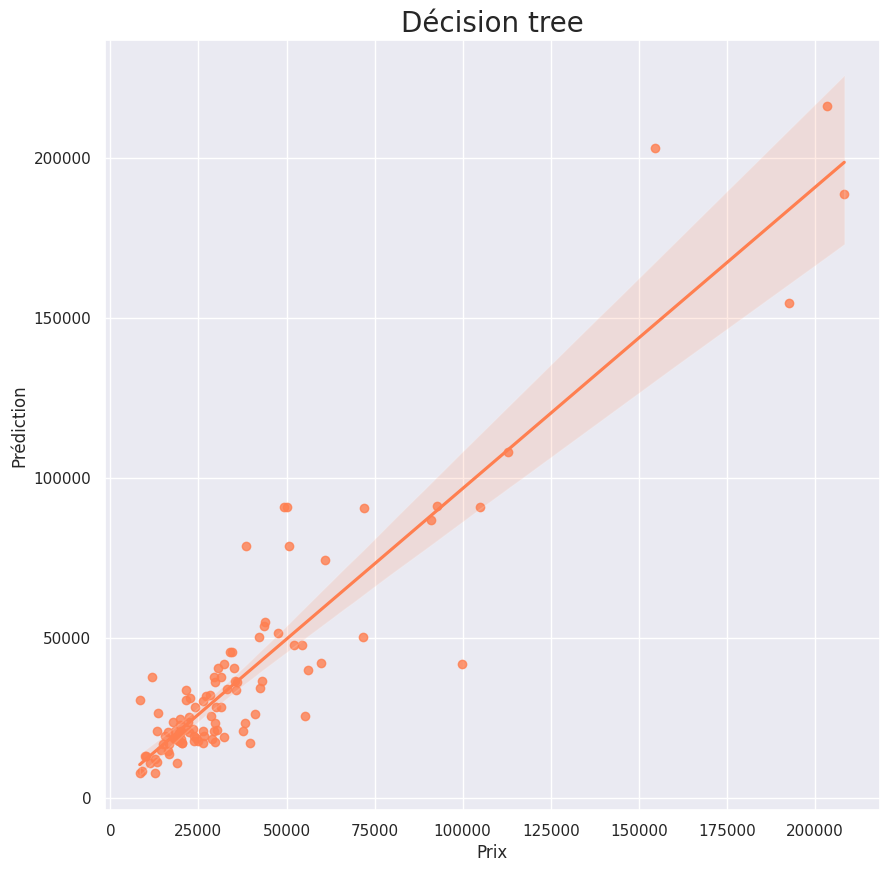

In [67]:
plt.figure(figsize = (10, 10))
sns.regplot(data = results, y = 'Prédiction', x = 'Prix', color = 'coral', marker = 'o')
plt.title("Décision tree", fontsize = 20)
plt.show()

In [68]:
model = MLPRegressor(hidden_layer_sizes = 50, alpha = 0.001, solver = 'lbfgs', learning_rate = 'adaptive')
model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Prédiction'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

error_mean_square.append(int(mean_squared_error(y_predict, y_test)))
error_mean_absolute.append(int(mean_absolute_error(y_predict, y_test)))

In [69]:
#print (model.coefs_)

result = model.score(X_test, y_test)
print(result)

-3107166915.554685


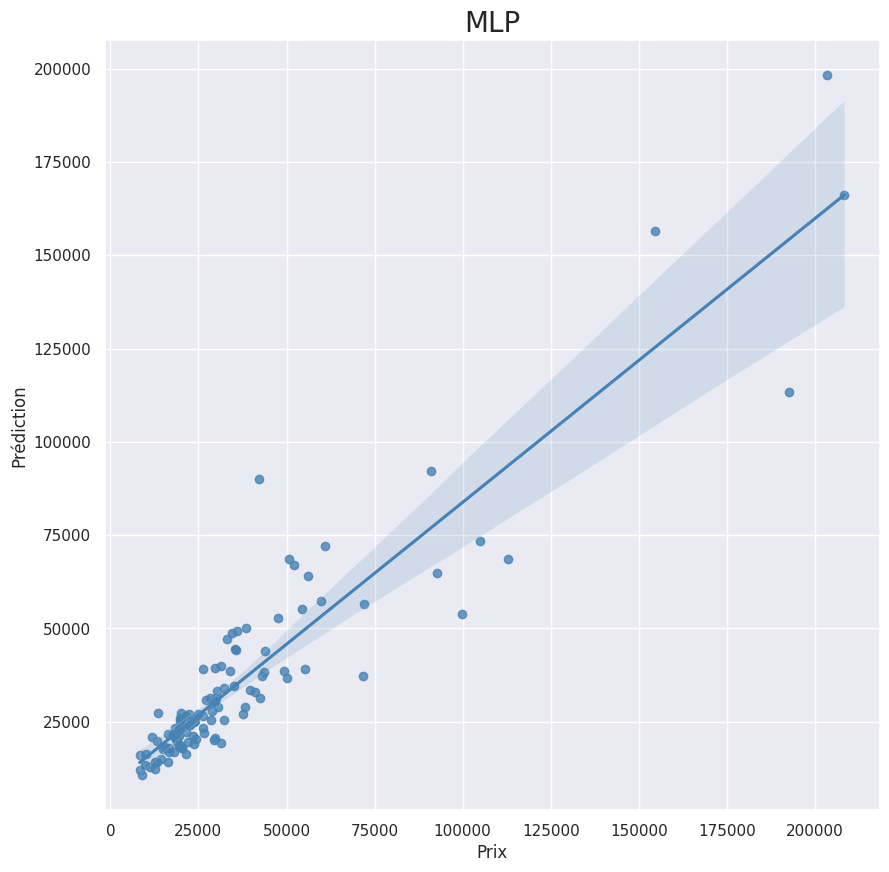

In [70]:
plt.figure(figsize = (10, 10))
sns.regplot(data = results, y = 'Prédiction', x = 'Prix', color = 'steelblue', marker = 'o')
plt.title("MLP", fontsize = 20)
plt.show()

In [71]:
error_mean_absolute

[10483, 9649, 9204, 8170]

In [72]:
error_mean_square

[259551621, 345516929, 202880509, 207513014]

In [73]:
# Comparaison des erreurs
data = {'Models': ['Regression linéaire', 'Regression voisine', 'Décision tree', 'MLP'], 'Mean Absolute Error': error_mean_absolute, 'Mean Squared Error': error_mean_square}
model_dataframe = pd.DataFrame(data)
model_dataframe

,Models,Mean Absolute Error,Mean Squared Error
0,Regression linéaire,10483,259551621
1,Regression voisine,9649,345516929
2,Décision tree,9204,202880509
3,MLP,8170,207513014


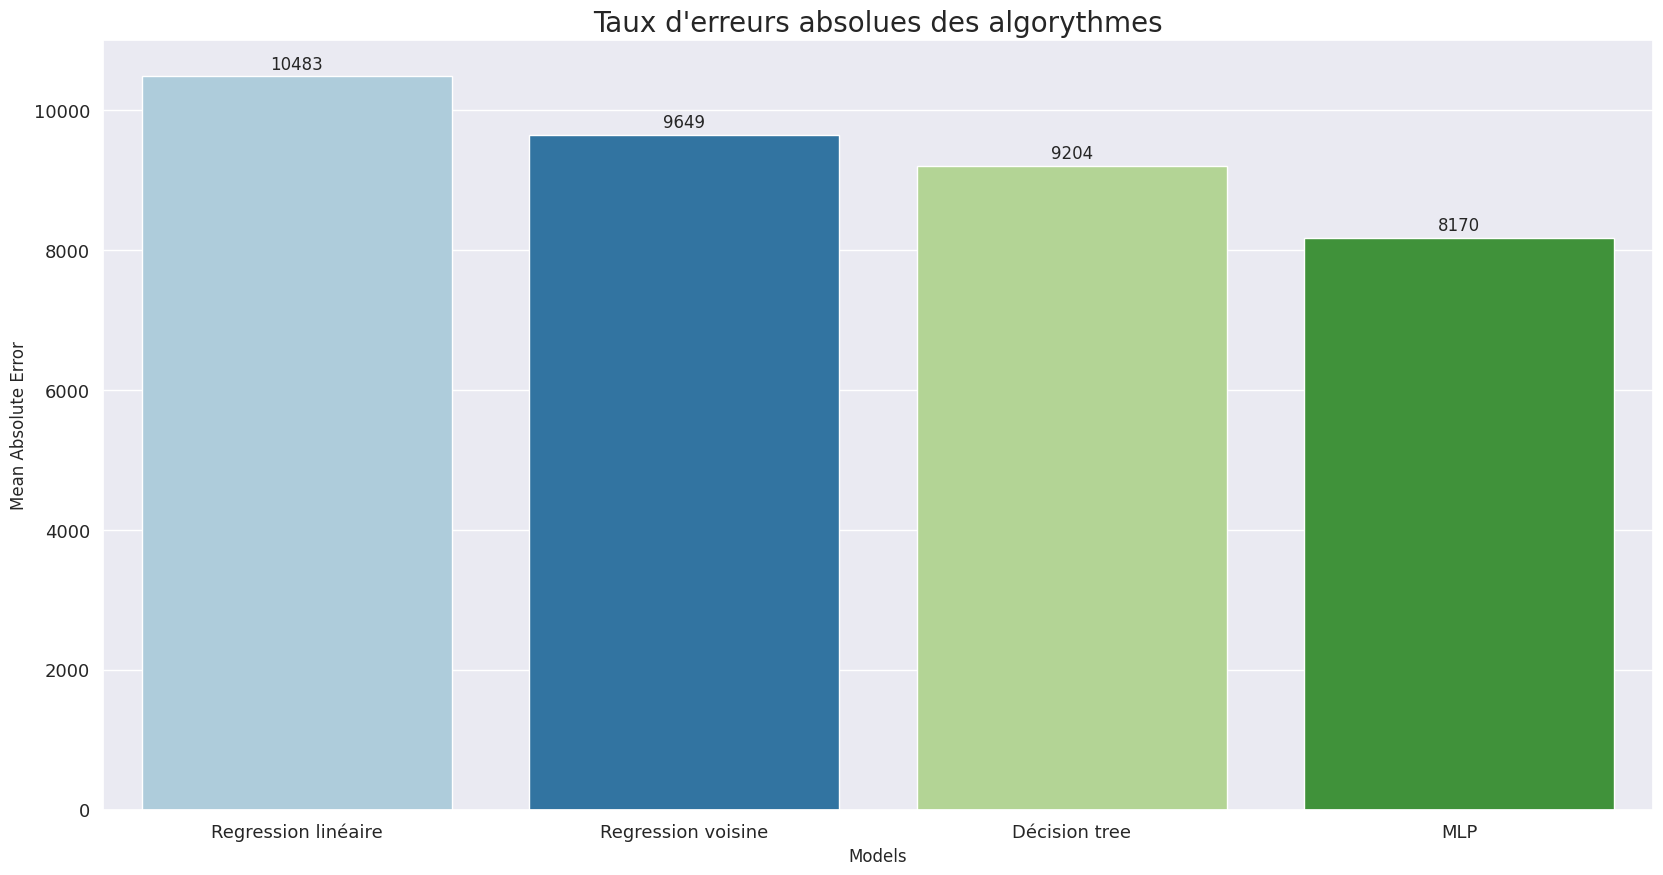

In [74]:
plt.figure(figsize = (20, 10))
splot = sns.barplot(data = model_dataframe, x = 'Models', y = 'Mean Absolute Error', palette = 'Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Taux d'erreurs absolues des algorythmes", fontsize = 20)
plt.show()

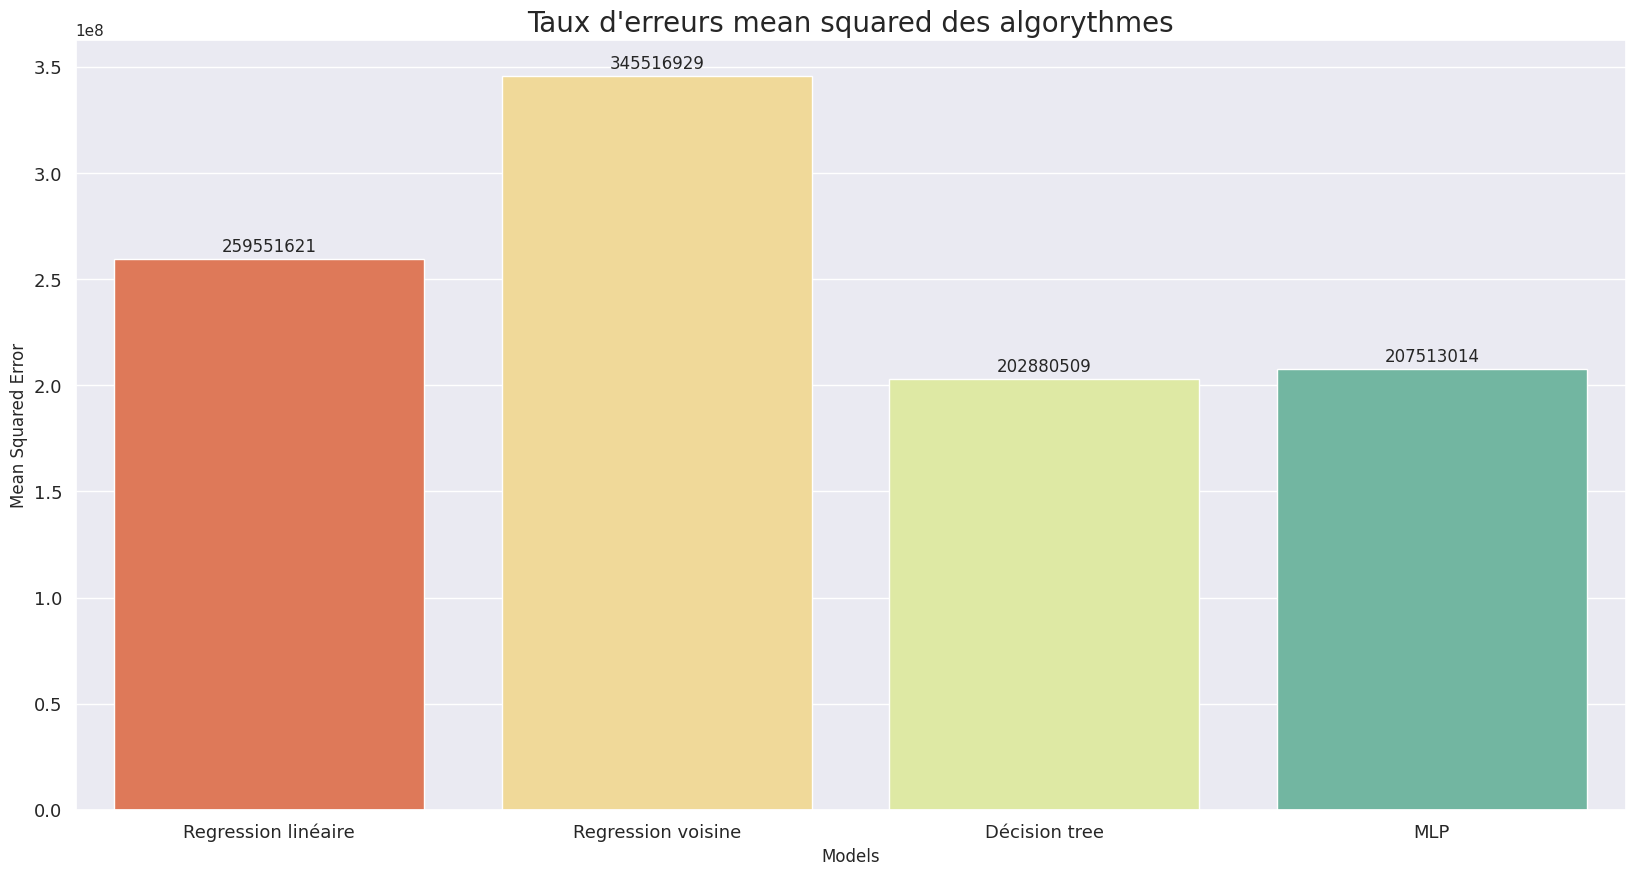

In [75]:
plt.figure(figsize = (20, 10))
splot = sns.barplot(data = model_dataframe, x = 'Models', y = 'Mean Squared Error', palette = 'Spectral')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Taux d'erreurs mean squared des algorythmes", fontsize = 20)
plt.show()

In [76]:
# Train MLP Regressor
model = MLPRegressor(hidden_layer_sizes = 50, alpha = 0.001, solver = 'lbfgs', learning_rate = 'adaptive')
model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Prédiction'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

In [77]:
# Export model
import pickle
filename = 'regressor_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [79]:
# Load Model
loaded_model = pickle.load(open('regressor_model.sav', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

-877631001.6079981


In [80]:
df.head()

,Prix,year,origin,firstHand,mileage,energy,gearbox,doors,ratedHorsePower,powerDIN,critAir,co2,owners
1,22770,2017,0,0,45,1,0,3,11,208,1,125,2.0
2,15100,2018,0,0,131,0,0,5,5,110,2,98,3.0
3,26710,2018,0,0,88,1,0,5,7,131,1,124,2.0
5,16780,2019,0,0,78,1,0,3,5,110,1,100,2.0
10,215120,2020,1,0,30,1,1,2,34,450,1,207,2.0


In [81]:
# Fir data to the mongodb return
test_car = df.head(1).drop("Prix", axis=1).to_dict("records")
X = pd.DataFrame(test_car)

In [84]:
# test prediction
scaler = MinMaxScaler()
scaler.fit(X)
X_test = scaler.transform(X)
y_predict = model.predict(X_test)
y_predict = pd.DataFrame(y_predict, columns = ['Prédiction'])

In [85]:
y_predict

,Prédiction
0,-8772.86557


In [88]:
import joblib
joblib.dump(model, "./model.joblib")

['./model.joblib']